This notebook contains the code required to generate Figures 2 and 3 from Hall et al. 2019.  

However, due to the long times required to generate the full figures the parameters in this notebook have been set to run in a shorter amount of time and the **plots produced will not exactly match the published figures**.  

**Comments in the code show how to change the parameters to generate the original figures**.  This would take approximately 15 minutes per simulation and requires 3000 simulations. 

In [1]:
from parameters import Parameters
from FitnessClasses import *
from simulation_scraping_disjoint import get_rsquared_all_sims
from plot_functions import plot_incomplete_moment_with_random_selection
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# To recreate the figures, change these variables:
# NUM_SIMULATIONS, GRID_SIZE, NEUTRAL_MUTATION_RATE, NEUTRAL_DIVISION_RATE and BIOPSY_LOCATIONS. 
# These are marked with *CHANGE FOR FIGURES*

NUM_SIMULATIONS = 5   # Increase to 1000 to recreate the figures. *CHANGE FOR FIGURES*

# Parameters for the simulations
GRID_SIZE = 200  # Increase to 500 to recreate the figures. *CHANGE FOR FIGURES*
NUM_CELLS = GRID_SIZE ** 2
MAX_TIME = 3000

NEUTRAL_MUTATION_RATE = 0.015 # Decrease to 0.001 to recreate the figures.  *CHANGE FOR FIGURES*
NEUTRAL_DIVISION_RATE = 0.033  # Increase to 0.5 to recreate the figures.  *CHANGE FOR FIGURES*
NON_NEUTRAL_MUTATION_RATE = 0.015
NON_NEUTRAL_DIVISION_RATE = 0.033

# Parameters for biopsy sampling
BIOPSY_EDGE = 70
BIOPSY_LOCATIONS = [0, 100]  # Use [0, 100, 200, 300, 400] to recreate the figures.  *CHANGE FOR FIGURES*

BIOPSIES = []
for i in BIOPSY_LOCATIONS:
    for j in BIOPSY_LOCATIONS:
        BIOPSIES.append({'biopsy_origin': (i, j), 'biopsy_edge': BIOPSY_EDGE}, )

COVERAGE = 1000
DETECTION_LIMIT = 10
FIXED_INTERVAL = 25 # Defining the size of the bins to group the clones into. Cell number

In [3]:
def get_non_neutral_cell_proportion(sim):
    neutral_cells = 0
    non_neutral_cells = 0
    for i in range(len(sim.clones_array)):
        pop = sim.population_array[i, -1]
        if pop > 0:
            fit = sim.clones_array[i, sim.fitness_idx]
            if fit == 1:
                neutral_cells += pop
            else:
                non_neutral_cells += pop

    non_neutral_proportion = non_neutral_cells/(neutral_cells + non_neutral_cells)
    return non_neutral_proportion

In [4]:
def run_simulations(p, output_dir, label):
    print('Running simulations')
    dnds_ratios = []
    non_neutral_cell_proportions = []
    for i in range(1, NUM_SIMULATIONS+1):
        # Run a simulation
        np.random.seed(i)
        sim_2D = p.get_simulator()
        sim_2D.run_sim()
        output_file = '{}/Moran2D_{}-{}.pickle'.format(output_dir, label, i)
        sim_2D.pickle_dump(output_file)
        dnds_ratios.append(sim_2D.get_dnds())
        non_neutral_cell_proportions.append(get_non_neutral_cell_proportion(sim_2D))
        print('Completed {} of {} simulations'.format(i, NUM_SIMULATIONS))

    print('Processing simulation results')
    # This will include all simulation results in the directory.
    res = get_rsquared_all_sims(output_dir, biopsies=BIOPSIES, coverage=COVERAGE, detection_limit=DETECTION_LIMIT,
                                fixed_interval=FIXED_INTERVAL)

    plot_incomplete_moment_with_random_selection(res,
                                                 x_vals=np.arange(0, 3000, FIXED_INTERVAL),
                                                 with_biopsy=False,
                                                 convert_to_clone_size=True,
                                                 biopsy_size=NUM_CELLS,
                                                 linecolour='k',
                                                 rangecolour='b',
                                                 num_shown=min(20, NUM_SIMULATIONS))
    plt.show()

    plot_incomplete_moment_with_random_selection(res,
                                                 x_vals=np.arange(0, 3000, FIXED_INTERVAL),
                                                 with_biopsy=True,
                                                 convert_to_clone_size=True,
                                                 biopsy_size=BIOPSY_EDGE**2,
                                                 linecolour='k',
                                                 rangecolour='b',
                                                 num_shown=min(20, NUM_SIMULATIONS))
    plt.show()
    
    # R2 values for clones sizes observed in the biopsies
    r_sq_values_biopsies = [v['biop_r2_interval'] for v in res.values()]
    # R2 values for all clones sizes. Sample size matched to the number of clones observed in the biopsies
    r_sq_values_full = [v['matched_r2_interval'] for v in res.values()]
    
    # nan values have to be excluded for the ROC curves to plot.
    # Only occur here due to the reduced size of the example simulations meaning there may not be enough clones 
    # observed when using biopsies. Not an issue using the full size simulations used in the paper.
    r_sq_values_biopsies = [x for x in r_sq_values_biopsies if not np.isnan(x)]
    r_sq_values_full = [x for x in r_sq_values_full if not np.isnan(x)]
    
    return dnds_ratios, non_neutral_cell_proportions, r_sq_values_full, r_sq_values_biopsies

# 1% non-neutral simulations

In [5]:
# Figures 2b, 3b 

============== Setting up ==============
Using a grid of 200x200
3960000 simulation_steps
Running simulations
Completed 1 of 5 simulations
Completed 2 of 5 simulations
Completed 3 of 5 simulations
Completed 4 of 5 simulations
Completed 5 of 5 simulations
Processing simulation results


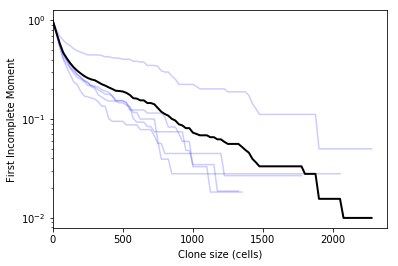

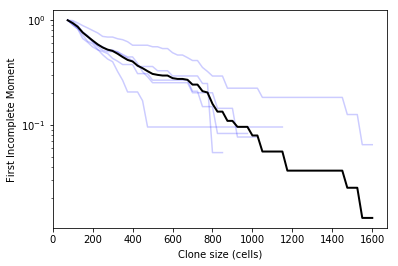

In [6]:
# Set up a directory to store the output of the simulations.
output_dir = 'non_neutral_1perc_simulations'
empty_dir = True
try:
    os.mkdir(output_dir)
    
except FileExistsError as e:
    for f in glob.glob("{}/*.pickle".format(output_dir)):
        print('.pickle files already exist in the {} directory. Remove before running.'.format(output_dir))
        empty_dir = False
        break

if empty_dir:
    # Define the synonymous proportion and fitness effect of the mutations added
    non_neutral_1perc_mutation_generator = MutationGenerator(combine_mutations='add',
                                                             mutation_distribution=NormalDist(std=0.1, mean=1.1),
                                                             synonymous_proportion=0.99)


    # Set up the parameters for the simulations
    p = Parameters(algorithm='Moran2D', mutation_generator=non_neutral_1perc_mutation_generator,
                      initial_cells=NUM_CELLS,
                      division_rate=NON_NEUTRAL_DIVISION_RATE, max_time=MAX_TIME,
                      mutation_rate=NON_NEUTRAL_MUTATION_RATE, samples=10)

    dnds_ratios_1perc, non_neutral_cell_proportions_1perc,\
        r_sq_values_full_1perc, r_sq_values_biopsies_1perc = run_simulations(p, output_dir, '1perc')

# 25% non-neutral simulations

In [7]:
# Figures 2c, 3c

============== Setting up ==============
Using a grid of 200x200
3960000 simulation_steps
Running simulations
Completed 1 of 5 simulations
Completed 2 of 5 simulations
Completed 3 of 5 simulations
Completed 4 of 5 simulations
Completed 5 of 5 simulations
Processing simulation results


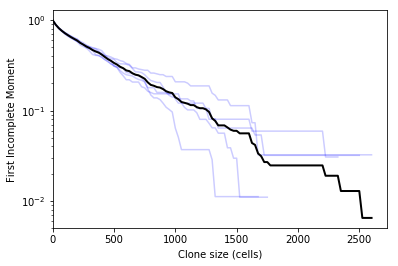

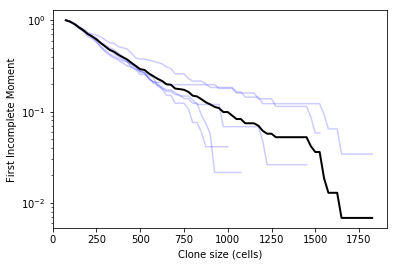

In [8]:
# Set up a directory to store the output of the simulations.
output_dir = 'non_neutral_25perc_simulations'
empty_dir = True
try:
    os.mkdir(output_dir)
except FileExistsError as e:
    for f in glob.glob("{}/*.pickle".format(output_dir)):
        print('.pickle files already exist in the {} directory. Remove before running.'.format(output_dir))
        empty_dir = False
        
if empty_dir:
    # Define the synonymous proportion and fitness effect of the mutations added
    non_neutral_25perc_mutation_generator = MutationGenerator(combine_mutations='add',
                                                              mutation_distribution=NormalDist(std=0.1, mean=1.1),
                                                              synonymous_proportion=0.75)

    # Set up the parameters for the simulations
    p = Parameters(algorithm='Moran2D', mutation_generator=non_neutral_25perc_mutation_generator,
                   initial_cells=NUM_CELLS,
                   division_rate=NON_NEUTRAL_DIVISION_RATE, max_time=MAX_TIME,
                   mutation_rate=NON_NEUTRAL_MUTATION_RATE, samples=10)

    dnds_ratios_25perc, non_neutral_cell_proportions_25perc,\
        r_sq_values_full_25perc, r_sq_values_biopsies_25perc = run_simulations(p, output_dir, '25perc')

# Neutral simulations

In [9]:
# Figures 2a, 3a

============== Setting up ==============
Using a grid of 200x200
3960000 simulation_steps
Running simulations
Completed 1 of 5 simulations
Completed 2 of 5 simulations
Completed 3 of 5 simulations
Completed 4 of 5 simulations
Completed 5 of 5 simulations
Processing simulation results


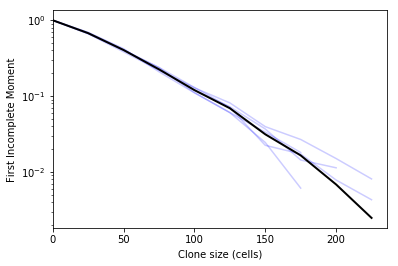

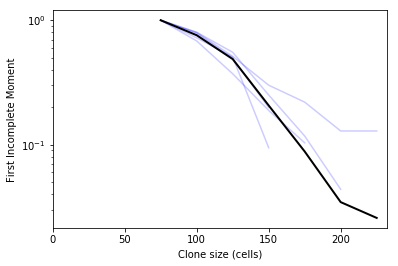

In [10]:
# Set up a directory to store the output of the simulations.
output_dir = 'neutral_simulations'
empty_dir = True
try:
    os.mkdir(output_dir)
except FileExistsError as e:
    for f in glob.glob("{}/*.pickle".format(output_dir)):
        print('.pickle files already exist in the {} directory. Remove before running.'.format(output_dir))
        empty_dir = False
    
if empty_dir:
    # Define the synonymous proportion and fitness effect of the mutations added
    # The non-synonymous mutations in this case have no effect on fitness but allow the calculation of a dnds ratio
    neutral_mutation_generator = MutationGenerator(combine_mutations='add',
                                                   mutation_distribution=FixedValue(1),
                                                   synonymous_proportion=0.5)

    p = Parameters(algorithm='Moran2D', mutation_generator=neutral_mutation_generator,
                           initial_cells=NUM_CELLS,
                           division_rate=NEUTRAL_DIVISION_RATE, max_time=MAX_TIME,
                           mutation_rate=NEUTRAL_MUTATION_RATE, samples=10)

    dnds_ratios_neutral, non_neutral_cell_proportions_neutral,\
        r_sq_values_full_neutral, r_sq_values_biopsies_neutral = run_simulations(p, output_dir, 'neutral')

# Non-neutral cell proportion plot

In [11]:
# Figure 2d

In [12]:
import seaborn as sns
sns.set_style('white')

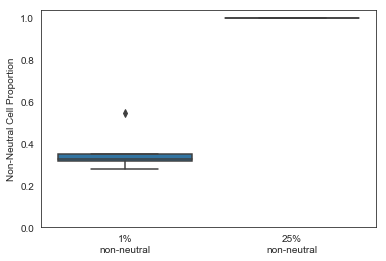

In [13]:
plot_df = pd.DataFrame({
    "params": ["1%\nnon-neutral"]*len(non_neutral_cell_proportions_1perc) + ["25%\nnon-neutral"]*len(non_neutral_cell_proportions_25perc),
    "Non-Neutral Cell Proportion": non_neutral_cell_proportions_1perc + non_neutral_cell_proportions_25perc
})
sns.boxplot(data=plot_df, x='params', y='Non-Neutral Cell Proportion')
plt.ylim(bottom=0)
plt.xlabel("");

# dN/dS plot

In [14]:
# Figure 2e

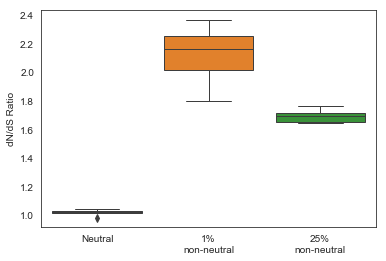

In [15]:
plot_df = pd.DataFrame({
    "params": ['Neutral']* len(dnds_ratios_neutral) + ["1%\nnon-neutral"]*len(dnds_ratios_1perc) + ["25%\nnon-neutral"]*len(dnds_ratios_25perc),
    "dN/dS": dnds_ratios_neutral + dnds_ratios_1perc + dnds_ratios_25perc
})
sns.boxplot(data=plot_df, x='params', y='dN/dS', linewidth=1, 
            order=['Neutral', "1%\nnon-neutral", "25%\nnon-neutral"])
plt.ylabel('dN/dS Ratio')
plt.xlabel("");

# ROC curves

In [16]:
# Figure 3d. Very low numbers of simulations means the small example will not clearly resemble the full published results.

In [17]:
import sklearn.metrics

def roc_curve(true_labels, r_squared, label, linestyle=None, colour=None, dashes=(1,1)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_labels, r_squared, pos_label=0)
    auc = sklearn.metrics.auc(fpr, tpr)
    print(label, 'AUC:', auc)
    if linestyle == '--':
        plt.plot(fpr, tpr, color=colour, linestyle=linestyle, dashes=dashes)
    else:
        plt.plot(fpr, tpr, color=colour, linestyle=linestyle, zorder=10)

1% non-neutral - full AUC: 0.68
1% non-neutral - biopsies AUC: 0.64
25% non-neutral - full AUC: 0.44000000000000006
25% non-neutral - biopsies AUC: 0.48


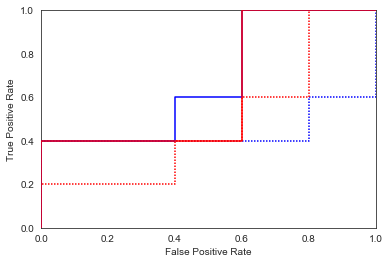

In [18]:
roc_curve(true_labels=[1]*len(r_sq_values_full_1perc) + [0]*len(r_sq_values_full_neutral), 
          r_squared=r_sq_values_full_1perc+r_sq_values_full_neutral, label='1% non-neutral - full',
         linestyle='-', colour='b')

roc_curve(true_labels=[1]*len(r_sq_values_biopsies_1perc) + [0]*len(r_sq_values_biopsies_neutral), 
          r_squared=r_sq_values_biopsies_1perc+r_sq_values_biopsies_neutral, label='1% non-neutral - biopsies',
         linestyle='-', colour='r')

roc_curve(true_labels=[1]*len(r_sq_values_full_25perc) + [0]*len(r_sq_values_full_neutral), 
          r_squared=r_sq_values_full_25perc+r_sq_values_full_neutral, label='25% non-neutral - full',
         linestyle='--', colour='b')

roc_curve(true_labels=[1]*len(r_sq_values_biopsies_25perc) + [0]*len(r_sq_values_biopsies_neutral), 
          r_squared=r_sq_values_biopsies_25perc+r_sq_values_biopsies_neutral, label='25% non-neutral - biopsies',
         linestyle='--', colour='r')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0, 1])
plt.ylim([0, 1]);